# Ubicación de generación estimada

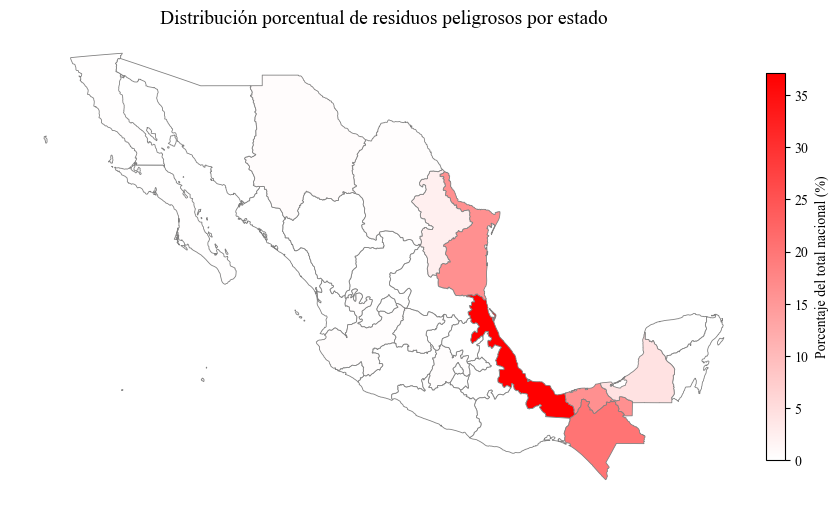

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from unidecode import unidecode

# Configurar fuente global
plt.rcParams["font.family"] = "Times New Roman"

# 1. Cargar datos
df = pd.read_csv("df_limpio.csv")
df.columns = df.columns.str.strip().str.lower()
df = df.groupby("estado_etiqueta", as_index=False)["generacion_estimada"].sum()

# Calcular porcentaje
df["generacion_estimada"] = df["generacion_estimada"] / df["generacion_estimada"].sum() * 100

# 2. Cargar GeoJSON
geo = gpd.read_file("https://raw.githubusercontent.com/angelnmara/geojson/master/mexicoHigh.json")
geo.columns = [unidecode(c).lower().strip() for c in geo.columns]

# 3. Normalizar
def norm_estado(s):
    return unidecode(str(s)).lower().replace("estado de ", "").strip()

geo["estado_norm"] = geo["name"].map(norm_estado)
df["estado_norm"] = df["estado_etiqueta"].map(norm_estado)

# 4. Unir datos y geometría
gdf = geo.merge(df, on="estado_norm", how="left")

# 5. Mapa
cmap = LinearSegmentedColormap.from_list("white_red", ["#ffffff", "#ff0000"])
vmax = float(gdf['generacion_estimada'].max(skipna=True) or 0)

fig, ax = plt.subplots(figsize=(10, 12))
gdf.plot(
    column="generacion_estimada",
    cmap=cmap,
    vmin=0, vmax=vmax,
    linewidth=0.6,
    edgecolor='gray',
    ax=ax,
    missing_kwds={"color": "lightgray", "label": "Sin dato"}
)

ax.set_axis_off()
ax.set_title("Distribución porcentual de residuos peligrosos por estado", fontsize=14)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.025, pad=0.01)
cbar.set_label("Porcentaje del total nacional (%)")

plt.show()



# Generación estimada por año

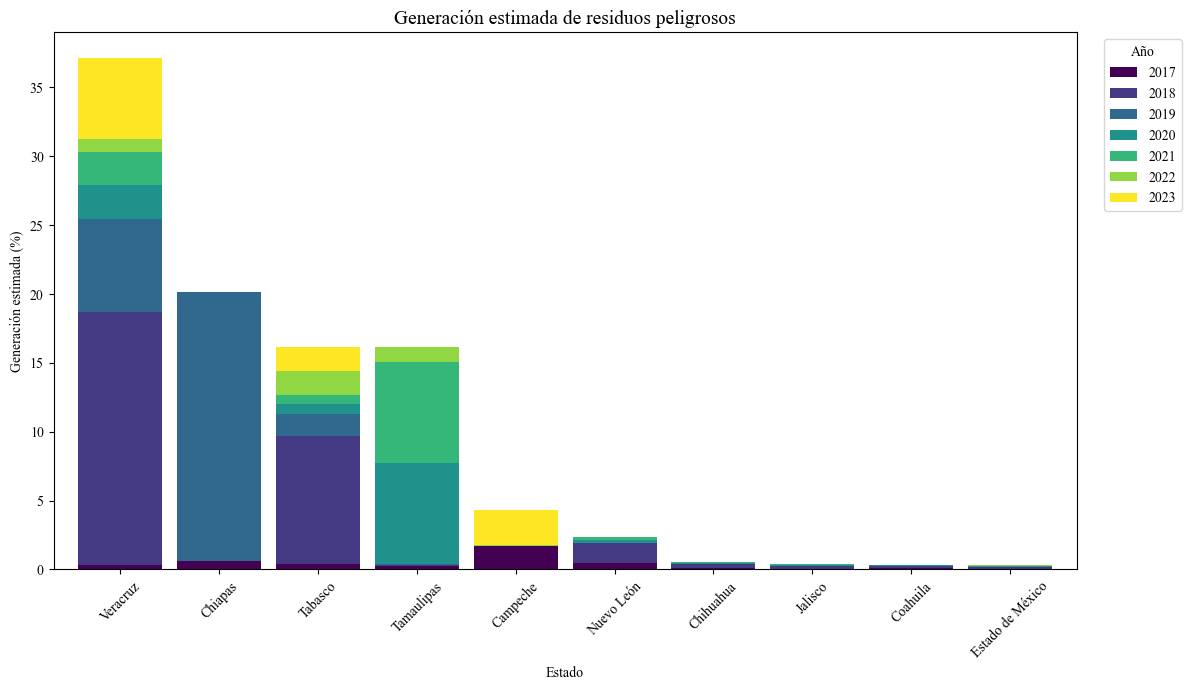

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Configurar fuente global
plt.rcParams["font.family"] = "Times New Roman"

# Cargar y preparar datos
df = pd.read_csv("df_limpio.csv")
df.columns = df.columns.str.strip().str.lower()

# Calcular porcentaje
df["generacion_estimada"] = df["generacion_estimada"] / df["generacion_estimada"].sum() * 100

# Agrupar por estado y año
df_grouped = df.groupby(["estado_etiqueta", "año"])["generacion_estimada"].sum().reset_index()

# Top 10 estados por generación total
top_estados = (
    df_grouped.groupby("estado_etiqueta")["generacion_estimada"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Filtrar solo top 10
df_top = df_grouped[df_grouped["estado_etiqueta"].isin(top_estados)].copy()

# Asegurar orden de los estados por generación total
estado_order = (
    df_top.groupby("estado_etiqueta")["generacion_estimada"]
    .sum()
    .sort_values(ascending=False)
    .index
)
df_top["estado_etiqueta"] = pd.Categorical(df_top["estado_etiqueta"], categories=estado_order, ordered=True)

# Pivot para acumulado por estado-año
pivot = df_top.pivot(index="estado_etiqueta", columns="año", values="generacion_estimada").fillna(0)

# Plot
pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 7),
    width=0.85,
    colormap="viridis"
)

# Estética
plt.title("Generación estimada de residuos peligrosos", fontsize=14)
plt.ylabel("Generación estimada (%)")
plt.xlabel("Estado")
plt.xticks(rotation=45)
plt.legend(title="Año", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


C:\Users\ingpa\AppData\Local\Temp\ipykernel_29552\92880999.py:35: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_frame.pivot_table(index="estado_etiqueta", columns="año", values="generacion_estimada").fillna(0)
C:\Users\ingpa\AppData\Local\Temp\ipykernel_29552\92880999.py:35: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_frame.pivot_table(index="estado_etiqueta", columns="año", values="generacion_estimada").fillna(0)
C:\Users\ingpa\AppData\Local\Temp\ipykernel_29552\92880999.py:35: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence t

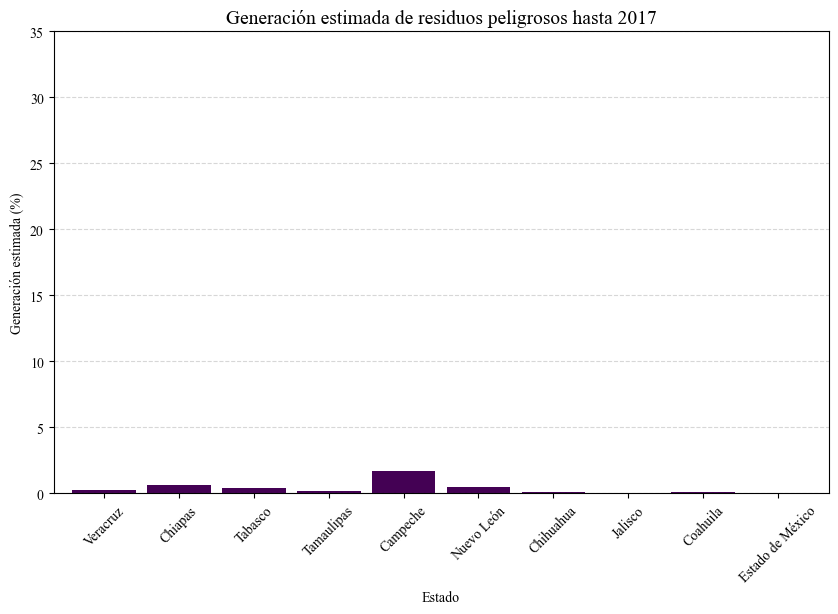

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Configuración
plt.rcParams["font.family"] = "Times New Roman"

# Leer y preparar datos
df = pd.read_csv("df_limpio.csv")
df.columns = df.columns.str.strip().str.lower()
df["generacion_estimada"] = df["generacion_estimada"] / df["generacion_estimada"].sum() * 100

df_grouped = df.groupby(["estado_etiqueta", "año"])["generacion_estimada"].sum().reset_index()
top_estados = (
    df_grouped.groupby("estado_etiqueta")["generacion_estimada"]
    .sum().sort_values(ascending=False).head(10).index
)
df_top = df_grouped[df_grouped["estado_etiqueta"].isin(top_estados)].copy()
estado_order = (
    df_top.groupby("estado_etiqueta")["generacion_estimada"]
    .sum().sort_values(ascending=False).index
)
df_top["estado_etiqueta"] = pd.Categorical(df_top["estado_etiqueta"], categories=estado_order, ordered=True)

# Años únicos ordenados
años = sorted(df_top["año"].unique())

# Crear figura
fig, ax = plt.subplots(figsize=(10, 6))

def update(frame):
    ax.clear()
    año_actual = años[frame]
    df_frame = df_top[df_top["año"] <= año_actual]
    pivot = df_frame.pivot_table(index="estado_etiqueta", columns="año", values="generacion_estimada").fillna(0)
    pivot = pivot[años[:frame+1]]  # cortar hasta el año actual
    pivot.plot(kind="bar", stacked=True, ax=ax, colormap="viridis", width=0.85, legend=False)

    ax.set_title(f"Generación estimada de residuos peligrosos hasta {año_actual}", fontsize=14)
    ax.set_ylabel("Generación estimada (%)")
    ax.set_xlabel("Estado")
    ax.set_ylim(0, 35)
    ax.set_xticklabels(pivot.index, rotation=45)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

ani = animation.FuncAnimation(fig, update, frames=len(años), interval=1000, repeat=False)

# Guardar GIF
ani.save("generacion_residuos.gif", writer="pillow", fps=1)
